# Transfer Learning for Jet Tagging in Particle Physics: FCNN

This is the first accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

## Background

Particle accelerator experiments at CERN produce massive amounts of data which non-ML analysis methods struggle to keep up with. A subset of these experiments concerns particle jets, which are streams of secondary particles created during the high energy collision of primary particles. Given a particle jet, we wish to rapidly identify the primary particles responsible for the jet in order to determine whether the experiment should be kept for further analysis.

Datastreams produced by these experiments contain "high-quality" information that would require massive amounts of memory to store. Our goal is then the following: can we train a "student" Neural Network to take in reduced, "low-quality" jet data and predict the primary particles that initiated the jet with the same accuracy as a "teacher" model trained on high-quality jet data? More simply, we will be performing a binary classification task to see whether our model can predict if the jet was initiated by a Top Quark ```label: 1``` or a "background" particle ```label: 0```.

Our code makes use of the [ATLAS Top Tagging Open Data Set](https://opendata.cern.ch/record/15013), a set of simulated jet events created by the ATLAS Collaboration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import seaborn as sns
import time
from preprocess import *
from helper import *
from visualize import *

# import warnings
# warnings.filterwarnings('ignore')  # pesky divide-by-zero errors

sns.set_theme()
plt.style.use("seaborn-v0_8")

In [2]:
# Initialize some global hyperparameters

NH = 5  # number of hidden layers: 5
NE = 30  # number of epochs
LR = 1.2e-5  # learning rate: 1.2e-5
BATCH_SZ = 250  # batch size: 250
MAX_ITEMS = 750000  # maximum number of elements to consider (input size): 3,000,000
MAX_CONSTITS = 80  # maximum number of constituent elements per jet: 80
REDUCED_CONSTITS = 80  # number of constituent elements for the Student network to consider: 40
NOISE_STD = 5e3  # noise standard deviation for the diffusion: 5e3
ALPHA = 0.5  # alpha parameter for knowledge transfer: 0.8
TEMP = 2.0  # temperature parameter for knowledge transfer: 2.0

#### Input Data Visualization

As a very first step, let's load in our data to see what it looks like. Our data has three attributes: "jet", "constituents", and "high-level" information about each jet. The jet attribute stores information about the *entire* jet: for example, the jet's mass and momentum. Meanwhile, the constituent attribute stores information about *each individual* particle that compose the jet: each particle's mass and momentum, for example. Finally, the high-level attribute stores variables "chosen in two separate studies of high level quantity based top taggers carried out by the ATLAS collaboration" (from the [reference manual](https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data/-/tree/master?ref_type=heads)). These high-level variables aren't super important, and we instead wish to train our model on the constituent attributes, which provide the most information to identify our jets.

In [3]:
jet_data, jet_labels, jet_weights, jet_features = get_data(
    "./data/reduced_atlas_dataset.h5", 
    attribute="jet",
)

cons_data, cons_labels, cons_weights, cons_features = get_data(
    "./data/train.h5", 
    attribute="constituents",
    max_items=MAX_ITEMS
)

print("---------- Jet-level data ----------------")
print("Data shape [input_size, num_features]:", jet_data.shape)
print("Feature names:", [human_feature(f) for f in jet_features],"\n")

print("---------- Constituent-level data ----------------")
print("Data shape [input_size, num_constituents, num_features]:", cons_data.shape)
print("Feature names:", [human_feature(f) for f in cons_features])

---------- Jet-level data ----------------
Data shape [input_size, num_features]: (10000, 4)
Feature names: ['jet pseudo-rapidity', 'jet mass', 'jet azimuthal angle', 'jet transverse momentum'] 

---------- Constituent-level data ----------------
Data shape [input_size, num_constituents, num_features]: (500000, 200, 4)
Feature names: ['constituent energy', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent transverse momentum']


As we can see, our features contain some important information about the jets: mass, energy, momentum, etc. We can visualize these features in a histogram:

In [4]:
# plot_1D_distributions(jet_data, jet_labels, jet_features, nbins=40, transparent=False, 
#                       # save_path="./jet_distribution.png",
#                       )

This histogram shows the distribution of jet mass, pseudo-rapidity, azimuthal angle, and energy by label. The human eye can clearly distinguish some patterns here! Now, let's see what the constituents' histograms look like:

In [5]:
# plot_1D_distributions(cons_data, cons_labels, cons_features, nbins=50, transparent=False, 
#                       # save_path="./constituent_distribution.png",
#                       )

At the constituent level, it is much harder (even for the human eye) to distinguish the signal curve from the background curve. Let's hope a neural network can help us with this!

### Preprocessing

The raw constituent-level data is unsuitable for training a deep neural network. First, the dynamic range in the energy and momentum needs to be accounted for. Next, the $\eta$ and $\phi$ don't contribute much information in their raw state, and must be transformed using the physically appropriate equations. This is done via the ```preprocess.consituent_preprocess``` function, adapted directly from the ATLAS collaboration.

In [6]:
pre_cons_data, pre_cons_features = constituent_preprocess(cons_data, cons_features, max_constits=MAX_CONSTITS)

print("Preprocessed constituent data shape:", pre_cons_data.shape)
print("Preprocessed features:", pre_cons_features)

/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:145: RuntimeWarning: divide by zero encountered in log
  log_pt = np.log(pt)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:146: RuntimeWarning: divide by zero encountered in log
  log_energy = np.log(energy)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:153: RuntimeWarning: divide by zero encountered in log
  lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:154: RuntimeWarning: divide by zero encountered in log
  lognorm_energy = np.log(energy / sum_energy[:,np.newaxis])


Preprocessed constituent data shape: (500000, 80, 7)
Preprocessed features: ['delta_eta' 'delta_phi' 'log_pt' 'log_E' 'lognorm_pt' 'lognorm_E' 'R']


Might as well try to visualize our new features!

In [7]:
# plot_preprocessed_1D_distributions(pre_cons_data, cons_labels, pre_cons_features, nbins=40)

It's getting a little abstract, but the main point is that these modified features should help our network perform better!

### Stage 1: Transfer Learning via FCNN

As a first step, we would like to ensure that we understand how to implement transfer learning. For this purpose, we will train a simple Teacher FCNN on the high quality ATLAS dataset. Next, we will downgrade this data via diffusion and downsampling, transfer knowledge from the Teacher to the Student FCCN, and train this Student on the lower quality data. We will then compare their performances.

First, we will train the Teacher FCNN on constituent-level data. For this purpose, we define the training loop function (in the notebook since it uses a lot of Global parameters)

In [8]:
from model import run_model, train_with_distillation

def training_loop(model, device, data, labels, weights, 
                  plot_confusion=False, teacher_model=None, alpha=ALPHA, temp=TEMP):
    """
    Run the whole training loop on the model given data, labels, and weights

    References a lot of global parameters
    """
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')  
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Data preparation
    train_set, val_set, test_set = standardize_split(data, labels, weights, train_split=0.7, val_split=0.15)
    train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

    loss_list, acc_list = [], []
    val_loss_list, val_acc_list = [], []

    t0 = time.time()
    for epoch in range(1,NE+1):

        # training -- with knowledge distillation
        if teacher_model:
            loss, acc = train_with_distillation(model, teacher_model, "fcnn",
                                                train_loader, criterion, optimizer, 
                                                device, alpha=alpha, temperature=temp)
            
        # training -- without knowledge distillation
        else:
            loss, acc = run_model(model, "fcnn", device, train_loader, criterion, optimizer=optimizer, train=True)

        loss_list.append(loss)
        acc_list.append(acc)

        # validation
        val_loss, val_acc, _, _ = run_model(model, "fcnn", device, val_loader, criterion, train=False)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        if epoch%5 == 0:
            print(f"E {epoch:02d} -- Train loss: {loss:.3f} -- Train acc: {acc:.3f} -- "\
                + f"Val loss: {val_loss:.3f} -- Val acc: {val_acc:.3f} -- t elapsed: {time_elapsed(t0,time.time())} mins"
        )
            
    # Testing on unseen data...
    test_loss, test_acc, fpr, tpr = run_model(
        model, "fcnn", device, test_loader, criterion, train=False,
        )
    

    # And finally plot the confusion matrix if desired
    if plot_confusion:

        true = []
        pred = []
        for d, l, w in test_set:
            d = d.unsqueeze(0)
            true.append(l.item())
            p = np.argmax(model(d.to(device)).cpu().detach().numpy())
            pred.append(p)

        plot_confusion_matrices(true, pred, "")
            
    return loss_list, acc_list, val_loss_list, val_acc_list, test_loss, test_acc, fpr, tpr

In [9]:
from model import JetFCNN

# model initialization
num_features=int(pre_cons_data.shape[1]*pre_cons_data.shape[2])
teacher_fcnn = JetFCNN(num_features=num_features, num_hidden_layers=NH)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device,"\n")

# Train and test the model
unpackable1 = training_loop(teacher_fcnn, device, pre_cons_data, cons_labels, cons_weights)

# Unpack results
teach_trainloss, teach_trainacc, teach_valloss, teach_valacc, teach_testloss, teach_testacc, fpr_teacher, tpr_teacher = unpackable1

Device: cuda 



/users/jmduchar/anaconda/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


E 05 -- Train loss: 0.563 -- Train acc: 0.724 -- Val loss: 0.513 -- Val acc: 0.759 -- t elapsed: 0.7 mins
E 10 -- Train loss: 0.497 -- Train acc: 0.762 -- Val loss: 0.468 -- Val acc: 0.783 -- t elapsed: 1.37 mins
E 15 -- Train loss: 0.464 -- Train acc: 0.781 -- Val loss: 0.440 -- Val acc: 0.796 -- t elapsed: 2.05 mins
E 20 -- Train loss: 0.444 -- Train acc: 0.792 -- Val loss: 0.425 -- Val acc: 0.807 -- t elapsed: 2.75 mins
E 25 -- Train loss: 0.431 -- Train acc: 0.800 -- Val loss: 0.420 -- Val acc: 0.811 -- t elapsed: 3.44 mins
E 30 -- Train loss: 0.421 -- Train acc: 0.805 -- Val loss: 0.411 -- Val acc: 0.814 -- t elapsed: 4.14 mins


#### Visualization

Teacher FCNN trained on high-quality data


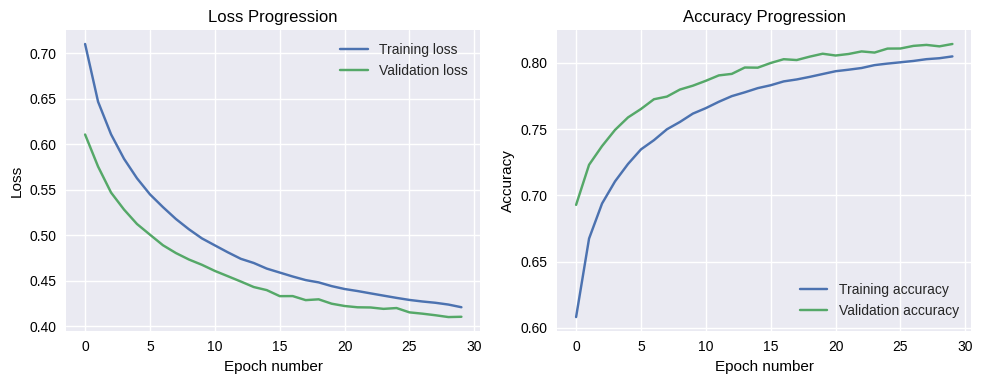

Final test loss: 0.4125	 Final test acc: 0.8149


In [10]:
print("Teacher FCNN trained on high-quality data")

plot_loss_and_accuracy(teach_trainloss, teach_valloss, teach_trainacc, teach_valacc, 
                       # transparent=True,
                       # save_path="./teacher_fcnn.png",
                       )

print(f"Final test loss: {teach_testloss:.4f}\t Final test acc: {teach_testacc:.4f}")

#### Degrade Data Quality

Next, we would like to train our Student network using the lower quality data. To obtain this lower quality data, we will simply take our available ("high-quality") data and diffuse it along the energy and momentum axes.

In [11]:
from helper import diffuse

diffused_cons_data = diffuse(cons_data, cons_features, noise_std=NOISE_STD, 
                             apply_features=['fjet_clus_E', 'fjet_clus_pt'],
                            )

We can visualize the results in a 1D histogram, shown below:

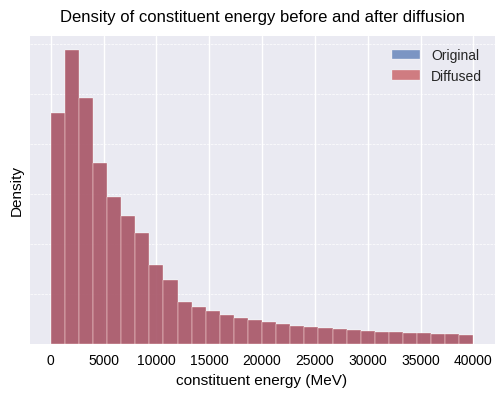

In [12]:
plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_E', xrange=[0,4e4],
                        transparent=False, 
                        save_path="./FCNN_diffusion_E.png",
                        )

plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_E', xrange=[0,4e4],
                        transparent=True, 
                        save_path="./FCNN_diffusion_E_transparent.png",
                        )

In [ ]:
plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_pt', xrange=[0,4e4],
                        transparent=False, 
                        save_path="./FCNN_diffusion_pt.png",
                        )

plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_pt', xrange=[0,4e4],
                        transparent=True, 
                        save_path="./FCNN_diffusion_pt_transparent.png",
                        )

Again, we'll preprocess the degraded data. Additionally, to introduce even more uncertainty, we will select a smaller subset of all constituents.

In [14]:
# run preprocessing again using the diffused data
diff_pre_cons_data, _ = constituent_preprocess(diffused_cons_data, cons_features, max_constits=REDUCED_CONSTITS)

# However, still need MAX_CONSTITS since the Teacher was trained with this size
padded_data = add_constits(diff_pre_cons_data, target_shape=MAX_CONSTITS)

Next, we want to train our Student model using this diffused data. To allow for a fair comparison, our Student network will have the same architecture and hyperparameters as the Teacher model.

In [15]:
# model initialization
student_no_distill = JetFCNN(num_features=num_features, num_hidden_layers=NH).to(device)

# Run the training loop
unpackable2 = training_loop(student_no_distill, device, padded_data, cons_labels, cons_weights)

# Unpack the results
stu_trainloss, stu_trainacc, stu_valloss, stu_valacc, stu_testloss, stu_testacc, fpr_student, tpr_student = unpackable2

/users/jmduchar/anaconda/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


E 05 -- Train loss: 0.553 -- Train acc: 0.726 -- Val loss: 0.512 -- Val acc: 0.752 -- t elapsed: 0.7 mins
E 10 -- Train loss: 0.529 -- Train acc: 0.741 -- Val loss: 0.500 -- Val acc: 0.758 -- t elapsed: 1.39 mins
E 15 -- Train loss: 0.517 -- Train acc: 0.748 -- Val loss: 0.497 -- Val acc: 0.762 -- t elapsed: 2.07 mins
E 20 -- Train loss: 0.510 -- Train acc: 0.752 -- Val loss: 0.492 -- Val acc: 0.764 -- t elapsed: 2.74 mins
E 25 -- Train loss: 0.505 -- Train acc: 0.754 -- Val loss: 0.490 -- Val acc: 0.764 -- t elapsed: 3.42 mins
E 30 -- Train loss: 0.501 -- Train acc: 0.757 -- Val loss: 0.489 -- Val acc: 0.766 -- t elapsed: 4.1 mins


Student FCNN trained on low-quality data without knowledge distillation


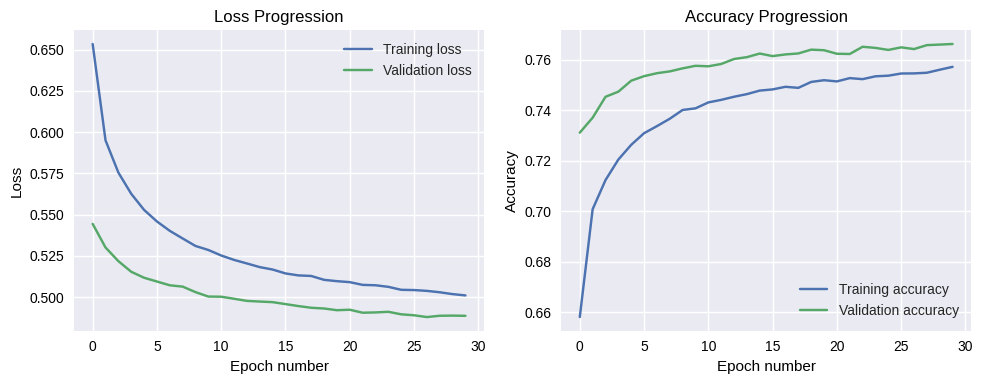

Final test loss: 0.4843	 Final test acc: 0.7714


In [16]:
print("Student FCNN trained on low-quality data without knowledge distillation")

plot_loss_and_accuracy(stu_trainloss, stu_valloss, stu_trainacc, stu_valacc,
                       # transparent=True,
                       # save_path="./student_fcnn_nodistill.png",
                       )
print(f"Final test loss: {stu_testloss:.4f}\t Final test acc: {stu_testacc:.4f}")

We see that the results are a bit worse with the diffused data. Now, it overfits because the data is too confusing! Let's see if some transfer of knowledge can help...

### Transfer Learning from the Teacher to the Student FCNN

In [17]:
# model initialization
student_fcnn = JetFCNN(num_features=num_features, num_hidden_layers=NH).to(device)

# run the training loop
unpackable3 = training_loop(student_fcnn, device, padded_data, cons_labels, cons_weights, teacher_model=teacher_fcnn, 
#                             alpha=0.5, temp=3,
                           )

# unpack results
dist_trainloss, dist_trainacc, dist_valloss, dist_valacc, dist_testloss, dist_testacc, fpr_distill, tpr_distill = unpackable3

/users/jmduchar/anaconda/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


E 05 -- Train loss: 0.577 -- Train acc: 0.692 -- Val loss: 0.545 -- Val acc: 0.733 -- t elapsed: 0.8 mins
E 10 -- Train loss: 0.554 -- Train acc: 0.709 -- Val loss: 0.529 -- Val acc: 0.738 -- t elapsed: 1.59 mins
E 15 -- Train loss: 0.543 -- Train acc: 0.717 -- Val loss: 0.532 -- Val acc: 0.740 -- t elapsed: 2.38 mins
E 20 -- Train loss: 0.537 -- Train acc: 0.722 -- Val loss: 0.525 -- Val acc: 0.742 -- t elapsed: 3.17 mins
E 25 -- Train loss: 0.534 -- Train acc: 0.724 -- Val loss: 0.522 -- Val acc: 0.740 -- t elapsed: 3.96 mins
E 30 -- Train loss: 0.530 -- Train acc: 0.726 -- Val loss: 0.523 -- Val acc: 0.739 -- t elapsed: 4.76 mins


Student FCNN trained on low-quality data with knowledge distillation


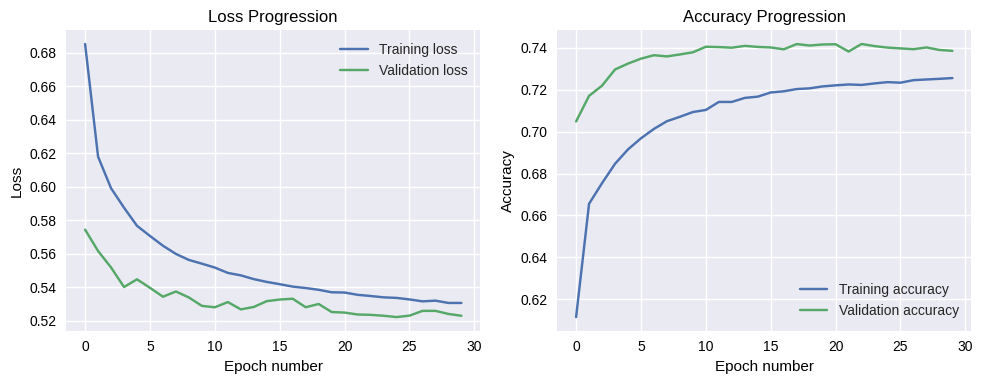

Final test loss: 0.5264	 Final test acc: 0.7347


In [18]:
print("Student FCNN trained on low-quality data with knowledge distillation")

plot_loss_and_accuracy(dist_trainloss, dist_valloss, dist_trainacc, dist_valacc,
                       # transparent=True,
                       # save_path="./student_fcnn_withdistill.png",
                       )

print(f"Final test loss: {dist_testloss:.4f}\t Final test acc: {dist_testacc:.4f}")

### ROC Curve Visualized

Finally, we visualize the Receiver Operating Characteristic Curve for...

1. Teacher trained on HQ data
2. Student trained on LQ data without distillation
3. Student trained on LQ data with distillation

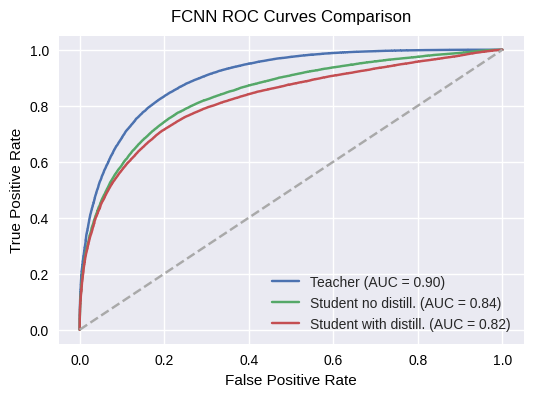

In [22]:
plot_roc(fpr_teacher, tpr_teacher, fpr_student, tpr_student, fpr_distill, tpr_distill, model_name="FCNN",
         transparent=False,
         save_path="./FCNN_ROC_diffusion.png"
         )

plot_roc(fpr_teacher, tpr_teacher, fpr_student, tpr_student, fpr_distill, tpr_distill, model_name="FCNN",
         transparent=True,
         save_path="./FCNN_ROC_diffusion_transparent.png"
         )

In [ ]:
# Check out what hardware we're running on
!nvidia-smi